# AOS AuxTel: update out-of-focus  WCS exposures using astrometric fitting of the in-focus exposure

Summary: 

   * the initial WCS in inspected auxTel images was off by ~180 degrees. Even after accounting for that it was ~100px off. 
   * we use a triad of images: in-focus, extra-focal, and intra-focal
   * we run `SourceDetectionTask` to detect position of sources  on the in-focus exposure
   * we  load reference catalog objects from the location given by ra,dec, rotation angle  with `ts_wep` `RefCatalogInterface`
   * we cross-match the detected sources catalog against reference catalog to correct the WCS  with `AstrometryTask`
   * we update the out-of-focus exposures with new WCS 
   * we run `ts_wep` `EstimateZernikesLatissTask` to estimate Zernikes based on the intra-focal and extra-focal images
   * we plot the resulting Zernike estimates and donut cutout stamps. All results are saved as a numpy pickle.
    

Technical details:
 * run on `lsst-devl02` with `w_2021_43` of the `lsst_distrib`
 * using `ts_wep` on `tickets/DM-31655` branch, rebased against `develop` 
 * last verified to run: `2021-10-25` 
 

1) Read in the extra, intra, and in-focus exposures:

In [1]:
from lsst.daf import butler as dafButler
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')


# exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
#                                      'exposure':2021090800487},
#                       collections=['u/scichris/Latiss/postISRtest'])


# exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
#                                      'exposure':2021090800488},
#                       collections=['u/scichris/Latiss/postISRtest'])

postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800489
                                        },
                      collections=['u/scichris/Latiss/postISRtest'])

Try the measuring PSF settings from Ian 

In [109]:
postIsr.hasPsf()

False

In [ ]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.meas.algorithms.installGaussianPsf import InstallGaussianPsfTask

installPsfTask = InstallGaussianPsfTask()
installPsfTask.run(postIsr)

charImageConfig = CharacterizeImageTask.ConfigClass()
charImageConfig.requireCrForPsf = False
charImageConfig.detection.thresholdValue = 1000
charImageConfig.detection.includeThresholdMultiplier = 1
charImageConfig.detection.thresholdType = "value"
charImageConfig.repair.cosmicray.nCrPixelMax = 10000000
charImageConfig.repair.cosmicray.min_DN = 10000

charImageTask = CharacterizeImageTask(config=charImageConfig)
charResult = charImageTask.run(postIsr)
#charResult = imCharTask.repair.run(postIsr)

In [ ]:
charImage.requireCrForPsf	False	i, g
charImage.detection.thresholdValue	10000	i
charImage.detection.thresholdValue	2500	g
charImage.detection.includeThresholdMultiplier	1.0	i, g
charImage.detection.thresholdType	“value”	i, g
charImage.repair.cosmicray.nCrPixelMax	10000000	i, g
charImage.repair.cosmicray.min_DN	10000	i
charImage.repair.cosmicray.min_DN

About measuring PSF 

    RHL 2017s notebook
    https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/PSF.ipynb
    
    
    Stack Club course: "Session 5: Source Detection and Measurement"
    https://github.com/LSSTScienceCollaborations/StackClubCourse/blob/master/Session05/lesson.ipynb
        
        

In [2]:
postIsr.hasPsf()

False

In [8]:
from copy import copy 
import numpy as np
exp = copy(postIsr)
arr = exp.mask.array
bad = arr & 2**exp.mask.getMaskPlaneDict()['BAD']
print(np.count_nonzero(bad))

# defects = butler.get("defects", visit=63264, ccd=70)
# >>> sum([x.getBBox().getArea() for x in defects])
# 221167

0


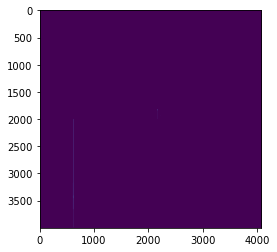

In [12]:
import matplotlib.pyplot as plt
plt.imshow(exp.mask.array)

In [30]:
mask = exp.mask

In [42]:
np.unique(mask.array)

array([  0,   6, 256, 262], dtype=int32)

In [43]:
mask

lsst.afw.image.image.MaskX=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], bbox=(minimum=(0, 0), maximum=(4071, 3999)), maskPlaneDict={'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7, 'UNMASKEDNAN': 9}

In [34]:
maskDict = mask.getMaskPlaneDict()

for key in maskDict.keys():
    value = maskDict[key]
    
    

{'BAD': 0,
 'CR': 3,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INTRP': 2,
 'NO_DATA': 8,
 'SAT': 1,
 'SUSPECT': 7,
 'UNMASKEDNAN': 9}

In [ ]:
Use firefly - open 

In [47]:
# this doesn't work 
import lsst.afw.display as afwDisplay
display2 = afwDisplay.Display(backend='firefly', url='http://lsst-demo.ncsa.illinois.edu/firefly')
display2.getClient().get_firefly_url()
display2.mtv(postIsr)

'http://lsst-demo.ncsa.illinois.edu/firefly/slate.html?__wsch=c2NpY2hyaXMyMDIxLTExLTA4'

In [55]:
# this doesn't work either
import lsst.afw.display as afwDisplay
display = afwDisplay.getDisplay(backend='ds9')
display.mtv(postIsr)

<Figure size 432x288 with 0 Axes>

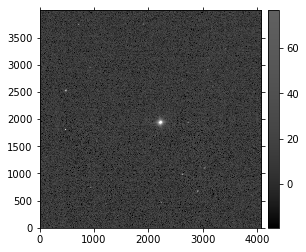

In [57]:
afwDisplay.setDefaultBackend('matplotlib')
plt.figure()                        #create a matplotlib.pyplot figure
display = afwDisplay.Display()      #get an alias to the lsst.afw.display.Display() method
display.scale('asinh', 'zscale')    #set the image stretch algorithm and range
display.mtv(postIsr.image)           #load the image into the display
plt.show()      

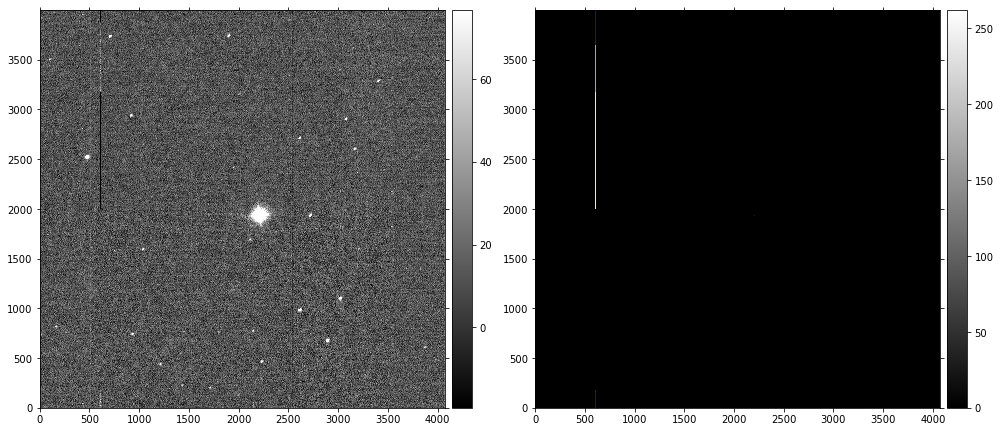

In [85]:
fig,ax = plt.subplots(1,2,figsize=(14,7))

plt.sca(ax[0]) # set the first axes as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(postIsr.image)

plt.sca(ax[1]) # set the second axes as current
display2 = afwDisplay.Display(frame=fig)
display2.mtv(postIsr.mask)
#display2.setMaskPlaneColor('NO_DATA','blue')
plt.tight_layout()


In [98]:
postIsr.mask.array > 0

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [100]:
postIsr.image.array

array([[  5.6577907 ,  13.905122  ,  14.800974  , ...,   4.965854  ,
         31.436356  ,  13.111629  ],
       [ 11.201324  ,  12.107666  ,  22.476854  , ...,   7.959168  ,
         10.578522  ,   8.235064  ],
       [ 17.105598  ,  -1.3379277 ,  19.281813  , ...,  -0.03641888,
          1.4927887 ,  26.563267  ],
       ...,
       [ -2.7542415 ,   8.618264  ,  14.168835  , ..., -10.292757  ,
         -5.8691072 ,  13.471566  ],
       [ -3.8854842 ,   8.475467  ,  15.84938   , ...,  28.071009  ,
         20.062754  ,  15.029114  ],
       [  2.4389756 ,  15.94829   ,  27.166012  , ...,  -2.4083216 ,
         18.036201  ,  21.97865   ]], dtype=float32)

In [104]:
np.sum(postIsr.mask.array == 0 )

16279414

It seems like an endless rabbit hole with no end in sight ! 

In [ ]:
plt.imshow(postIsr.image.array[np.where()])

In [88]:
display2.getMaskPlaneColor()

{'BAD': 'red',
 'CR': 'magenta',
 'EDGE': 'yellow',
 'INTERPOLATED': 'green',
 'SATURATED': 'green',
 'DETECTED': 'blue',
 'DETECTED_NEGATIVE': 'cyan',
 'SUSPECT': 'yellow',
 'NO_DATA': 'orange',
 'INTRP': 'green',
 'SAT': 'green'}

In [74]:
postIsr.mask.array[np.where(postIsr.mask.array > 0 )]

array([6, 6, 6, ..., 6, 6, 6], dtype=int32)

In [77]:
np.unique(postIsr.mask.array)

array([  0,   6, 256, 262], dtype=int32)

In [78]:
postIsr.mask

lsst.afw.image.image.MaskX=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], bbox=(minimum=(0, 0), maximum=(4071, 3999)), maskPlaneDict={'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7, 'UNMASKEDNAN': 9}

<Figure size 720x720 with 0 Axes>

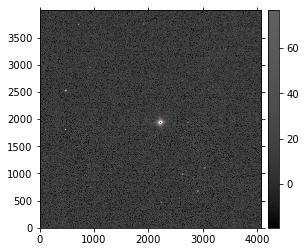

In [84]:
fig = plt.figure(figsize=(10,10))                                     #create a matplotlib.pyplot figure
afw_display = afwDisplay.Display()               #get an alias to the lsst.afw.display.Display() method
afw_display.scale('asinh', 'zscale')             #set the image stretch algorithm and range
afw_display.setMaskTransparency(0.4)             #set the transparency of the mask plane (1 = opaque)
afw_display.setMaskPlaneColor('DETECTED','blue') #set the color for a single plane in the mask
afw_display.setMaskPlaneColor('INTRP', 'yellow')
afw_display.setMaskPlaneColor('NO_DATA','orange')
afw_display.setMaskPlaneColor('SAT', 'red')
afw_display.mtv(postIsr)                          #load the image and mask plane into the display
plt.show()                                       #show the corresponding pyplot figure

In [60]:
print("Mask plane bit definitions:\n", display2.getMaskPlaneColor())  # Print the colors associated to each plane in the mask
print("\nMask plane methods:\n")
help(display2.setMaskPlaneColor)

Mask plane bit definitions:
 {'BAD': 'red', 'CR': 'magenta', 'EDGE': 'yellow', 'INTERPOLATED': 'green', 'SATURATED': 'green', 'DETECTED': 'blue', 'DETECTED_NEGATIVE': 'cyan', 'SUSPECT': 'yellow', 'NO_DATA': 'orange', 'INTRP': 'green', 'SAT': 'green'}

Mask plane methods:

Help on method setMaskPlaneColor in module lsst.afw.display.interface:

setMaskPlaneColor(name, color=None) method of lsst.afw.display.interface.Display instance
    Request that mask plane name be displayed as color
    
    Parameters
    ----------
    name : `str` or `dict`
        Name of mask plane or a dictionary of name -> colorName
    color : `str`
        The name of the color to use (must be `None` if ``name`` is a `dict`)
    
        Colors may be specified as any X11-compliant string (e.g. `"orchid"`), or by one
        of the following constants in `lsst.afw.display` : `BLACK`, `WHITE`, `RED`, `BLUE`,
        `GREEN`, `CYAN`, `MAGENTA`, `YELLOW`.
    
        If the color is "ignore" (or `IGNORE`) then

In [4]:
from lsst.pipe.tasks.repair import RepairTask
repair = RepairTask(name="RepairTask")
repair.run(postIsr)# , defects=defectList)

AssertionError: No PSF provided

In [4]:
# from Merlin

from lsst.meas.algorithms.installGaussianPsf import InstallGaussianPsfTask,InstallGaussianPsfConfig
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig


def measurePsf(exp):
    PLATESCALE = 0.095695

    imCharConfig = CharacterizeImageTask.ConfigClass()
    imCharConfig.doMeasurePsf = True
    imCharConfig.useSimplePsf = True

    imCharConfig.doApCorr = False
    imCharConfig.doDeblend = False

    installConfig = InstallGaussianPsfConfig()
    exp.setPsf(None)  # if not set to none, fwhm max para is ignored
    installConfig.fwhm = 25
    installConfig.width = 61

    imCharConfig.installSimplePsf = installConfig    

    imCharConfig.detection.includeThresholdMultiplier = 5

    imCharConfig.measurePsf.starSelector['objectSize'].doFluxLimit = True
    imCharConfig.measurePsf.starSelector['objectSize'].fluxMin = 12500.0
    imCharConfig.measurePsf.starSelector['objectSize'].fluxMax = 0.0
    imCharConfig.measurePsf.starSelector['objectSize'].doSignalToNoiseLimit = False
    imCharConfig.measurePsf.starSelector['objectSize'].signalToNoiseMin = 20.0
    imCharConfig.measurePsf.starSelector['objectSize'].signalToNoiseMax = 0.0
    imCharConfig.measurePsf.starSelector['objectSize'].widthMin = 0.0
    imCharConfig.measurePsf.starSelector['objectSize'].widthMax = 80.0  # default 10
    imCharConfig.measurePsf.starSelector['objectSize'].sourceFluxField = "base_GaussianFlux_instFlux"
    imCharConfig.measurePsf.starSelector['objectSize'].widthStdAllowed = 0.15 # 0.15 default
    imCharConfig.measurePsf.starSelector['objectSize'].nSigmaClip = 2.0

    imCharConfig.requireCrForPsf= False
    imCharConfig.background.binSize = 2000
    imCharConfig.background.approxOrderX = 2
    imCharConfig.measurePsf.psfDeterminer['psfex'].spatialOrder = 1
    imCharConfig.repair.cosmicray.nCrPixelMax = int(1e6)
    imCharConfig.detection.background = imCharConfig.background

    imCharTask = CharacterizeImageTask(config=imCharConfig)

    result = imCharTask.run(exp)

    psf = exp.getPsf()
    ixx = psf.computeShape(exp.getBBox().getCenter()).getIxx()
    iyy = psf.computeShape(exp.getBBox().getCenter()).getIyy()
    psfShape = psf.computeShape(exp.getBBox().getCenter()).getDeterminantRadius()

    fwhmX = np.sqrt(ixx)*2.355*PLATESCALE
    fwhmY = np.sqrt(iyy)*2.355*PLATESCALE

    overallFwhm = psfShape * 2.355 * PLATESCALE
    print(f"Psf shape from imChar task (x,y) = ({fwhmX:.3f}, {fwhmY:.3f}) FWHM arcsec")
    return fwhmX, fwhmY, overallFwhm



In [5]:
fwhmX, fwhmY, overallFwhm = measurePsf(postIsr)

Skipping cosmic ray detection: Too many CR pixels (max 1000000)
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+b21ea61266/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+b21ea61266/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
NOT scaling kernelSize by stellar quadrupole moment, but using absolute value
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/pipe_tasks/21.0.0-165-g4927fbd8+b0a7cc4645/python/lsst/pipe/tasks/

InvalidParameterError: 
  File "src/PsfexPsf.cc", line 233, in virtual std::shared_ptr<lsst::afw::image::Image<double> > lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const Point2D&, const lsst::afw::image::Color&, const Point2D&) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


In [ ]:
repair = RepairTask(name="RepairTask")
repair.run(exp, defects=defectList)

In [ ]:
# # From Ioana 

# from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
# imCharTask = CharacterizeImageTask()
# imCharTask.run(postIsr)
# psf = postIsr.getPsf()
# shape = psf.computeShape()
# fwhm_Image = shape.getDeterminantRadius()*2.355*0.097

In [105]:
from lsst.meas.algorithms.installGaussianPsf import InstallGaussianPsfTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

installPsfTask = InstallGaussianPsfTask()
installPsfTask.run(postIsr)


In [106]:
postIsr.hasPsf()

True

In [5]:
psf = postIsr.getPsf()

In [7]:
image = psf.computeKernelImage()

/tmp/ipykernel_3330190/987825851.py:1: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  image = psf.computeKernelImage()


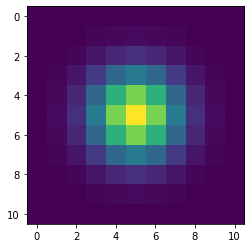

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.imshow(image.array)

For `lsst.rapid.analysis` to work, I needed to clone from github repo. It has a dependency on `lsst.atmospec`, which also needed to be git-cloned:

   ssh lsst-devl02
   lsst 
   
   
   cd /project/scichris/
   git clone https://github.com/LSSTDESC/Spectractor.git
   cd Spectractor
   pip install -r requirements.txt .
   
   git clone https://github.com/lsst-dm/atmospec.git
   cd atmospec
   setup -k -r .
   scons 
   
   git clone https://github.com/lsst-sitcom/rapid_analysis.git
   cd rapid_analysis
   setup -k -r .
   scons 
   
   
as well as `spectractor` https://github.com/LSSTDESC/Spectractor   https://freesoft.dev/program/124891820 

In [3]:
# Import BestEffortIsr
from lsst.rapid.analysis.bestEffort import BestEffortIsr
#Instantiate bestEffort
bestEffort = BestEffortIsr('/repo/main/', instrument='LATISS')   

/project/scichris/rapid_analysis/python/lsst/rapid/analysis/visitCheck.py:132: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def runDataRef(self, dataRef):


ModuleNotFoundError: No module named 'lsst.atmospec'

In [3]:
  
# Change here the repo in NCSA/Summit
### The Best Effort ISR for AuxTel image
data_id = {'instrument': 'LATISS', 'exposure': 2021100500254 , 'detector':0} 
postIsr = bestEffort.getExposure(data_id)   
psf = postIsr.getPsf()
 # You can actually configure plenty of parameters here, this is the default.
shape = psf.computeShape()
fwhm_Image = shape.getDeterminantRadius()*2.355*0.097

NameError: name 'bestEffort' is not defined

In [ ]:
from lsst.meas.algorithms.installGaussianPsf import InstallGaussianPsfTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

installPsfTask = InstallGaussianPsfTask()
installPsfTask.run(postIsr)

imCharConfig = CharacterizeImageTask.ConfigClass()
imCharConfig.doMeasurePsf = False
imCharConfig.doApCorr = False
imCharConfig.doDeblend = False
imCharConfig.repair.cosmicray.nCrPixelMax = int(1e7)
imCharConfig.requireCrForPsf= False

imCharTask = CharacterizeImageTask(config=imCharConfig)

charResult = imCharTask.repair.run(postIsr)

In [29]:
import lsst.geom as lsstGeom
myPoint = lsstGeom.Point2D(400,500)
myPsf = postIsr.getPsf().computeImage(myPoint)
plt.imshow(myPsf.getArray())

InvalidParameterError: 
  File "src/PsfexPsf.cc", line 233, in virtual std::shared_ptr<lsst::afw::image::Image<double> > lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const Point2D&, const lsst::afw::image::Color&, const Point2D&) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


2) Use the in-focus image to do source detection, and  do astrometry matching against  a reference catalog to obtain an updated WCS

In [56]:
#Set up the task, it requires a config when we instantiate it
charConfig = CharacterizeImageConfig()
charImageTask = CharacterizeImageTask(None, config=charConfig)
#run the task on our exposure and save the output. This takes a minute to run 
charResult = charImageTask.run(postIsr)

/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+5f62c5d854/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()


InvalidParameterError: 
  File "src/PsfexPsf.cc", line 233, in virtual std::shared_ptr<lsst::afw::image::Image<double> > lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const Point2D&, const lsst::afw::image::Color&, const Point2D&) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


In [14]:
postIsr.setPsf(None)

In [15]:
postIsr.hasPsf()

False

In [16]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

#Set up the task, it requires a config when we instantiate it
charConfig = CharacterizeImageConfig()
charConfig.requireCrForPsf= False

charImageTask = CharacterizeImageTask(None, config=charConfig)
#charImageTask.installSimplePsf.fwhm=2

#run the task on our exposure and save the output. This takes a minute to run 
charResult = charImageTask.run(postIsr)

Skipping cosmic ray detection: Too many CR pixels (max 10000)
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+b21ea61266/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+b21ea61266/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
NOT scaling kernelSize by stellar quadrupole moment, but using absolute value

> WARNING: 1st context group-degree lowered (not enough samples)


> WARNING: 1st context group removed (not enough samples)

/software/lssts

InvalidParameterError: 
  File "src/PsfexPsf.cc", line 233, in virtual std::shared_ptr<lsst::afw::image::Image<double> > lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const Point2D&, const lsst::afw::image::Color&, const Point2D&) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


Since that fails, try defining PSF manually:

Define the PSF to fit:

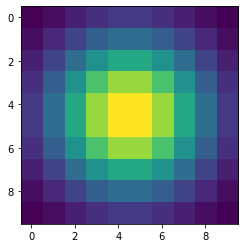

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay


def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)
#Run detection and measure on the correlated image using the simple PSF
#NOTE should look at which centroid is run to see if there are better ones
#psf_array = gkern(l=11, sig=2.5)
psf_array = gkern(l=10, sig=2.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)
plt.imshow(psf_image.array)

postIsr.setPsf(psf)

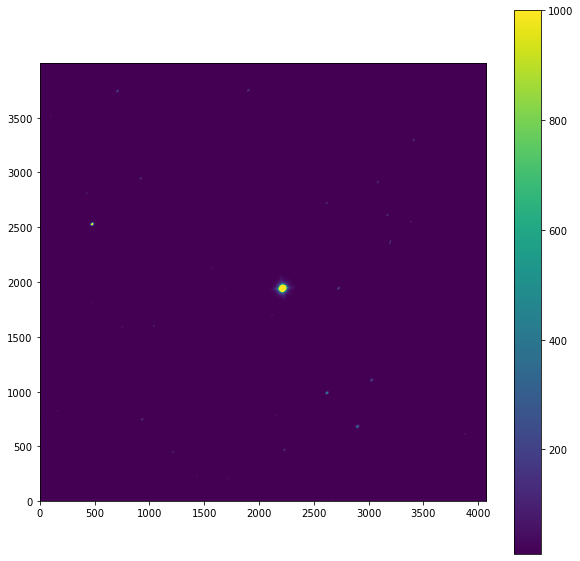

In [45]:
fig = plt.figure(figsize=(10,10))
plt.imshow(postIsr.image.array, origin='lower', vmin=10, vmax=1000)
plt.colorbar()

In [39]:
focusZVal0, focusZVal1 = [1,1.1]  #[-1,1] # [-1,-1.2]

focuszPair = (focusZVal0, focusZVal1)
extraExp = min(focuszPair)
intraExp = max(focuszPair)

expDicIdx = {focusZVal0:0, focusZVal1:1}
print(intraExp, extraExp)
print(f'{intraExp}, id={expDicIdx[intraExp]}, intra,/nwhile  {extraExp}, id={expDicIdx[extraExp]} is extra')

1.1 1
1.1, id=1, intra,/nwhile  1, id=0 is extra


In [28]:
focusZVal1

-1.2

Run source detection:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay


#Use DM tasks to run: detection, measure using the simple PSF (no deblending)
#From Merlin: It's usually a good idea to construct all Tasks before using any of them, mostly
# to define the full schema of any catalogs we'll produce up front.

schema = lsst.afw.table.SourceTable.makeMinimalSchema()

configDetection = SourceDetectionTask.ConfigClass()
configDetection.thresholdValue = 5 #30  # detection threshold in units of thresholdType
configDetection.thresholdType = "stdev"#"stdev"   # units for thresholdValue
configDetection.includeThresholdMultiplier = 1.0 
#configDetection.minPixels = 200 # 1000#
configDetection.minPixels = 200
#configDetection.charImage.background.weighting = False  
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)


measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table

#create copy of image to explicitly set the PSF
from copy import deepcopy
exposure = deepcopy(postIsr)
exposure.setPsf(psf)

# Run the detect the measure tasks
detect_result = detect.run(table, exposure,)# weighing=False)

catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
measure.run(catalog, exposure)

/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+5f62c5d854/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+5f62c5d854/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


RuntimeError: 
  File "src/math/Approximate.cc", line 177, in lsst::afw::math::{anonymous}::ApproximateChebyshev<PixelT>::ApproximateChebyshev(const std::vector<double>&, const std::vector<double>&, const lsst::afw::image::MaskedImage<ImagePixelT1, int, float>&, const lsst::geom::Box2I&, const lsst::afw::math::ApproximateControl&) [with PixelT = float]
    No valid points to fit. Variance is likely zero. Try weighting=False {0}
lsst::pex::exceptions::RuntimeError: 'No valid points to fit. Variance is likely zero. Try weighting=False'


Plot the source catalog:

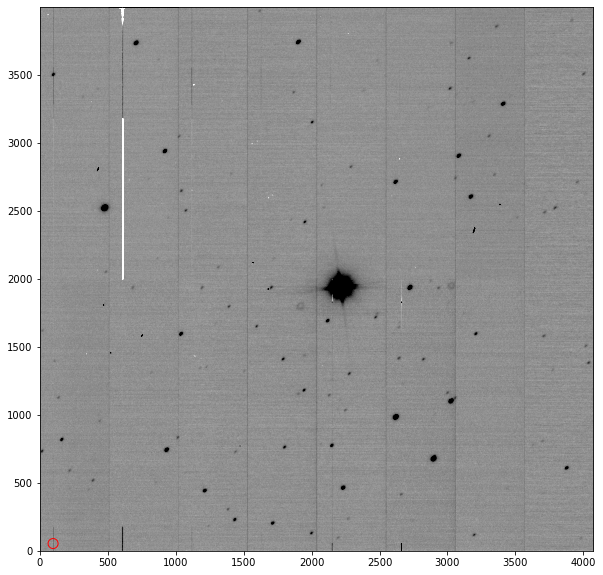

In [17]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()
data = postIsr.getImage().getArray()
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(catalog['slot_Centroid_x'], catalog['slot_Centroid_y'],s=100,facecolors='none', edgecolors='red',)

In [18]:
catalog

<class 'lsst.afw.table.SourceCatalog'>
 id      coord_ra         coord_dec     ... base_Variance_value base_Variance_flag_emptyFootprint
           rad               rad        ...                                                      
--- ----------------- ----------------- ... ------------------- ---------------------------------
  1 5.387414637273467 -1.52629601537023 ...  1.6148183345794678                             False

Ok, looks good! 

Use the new `RefCatalogInterface` from `ts_wep` to load the reference catalog for astrometry matching:

In [53]:
# need to provide ra,dec, rotation angle of the exposure 
visitInfo = postIsr.getInfo().getVisitInfo()

boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

In [54]:
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface

refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)

shardIds = refCatInterface.getShardIds()

from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
catalogName = 'gaia_dr2_20200414'
collections = 'refcats'

dataRefs, dataIds = refCatInterface.getDataRefs(shardIds, butler, catalogName, collections)

from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (GenerateDonutCatalogWcsTask, 
                                                             GenerateDonutCatalogWcsTaskConfig)

donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
donutCatConfig.filterName= 'phot_g_mean'

# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }

/project/scichris/aos/ts_wep/python/lsst/ts/wep/task/DonutSourceSelectorTask.py:84: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def selectSources(self, sourceCat, matches=None, exposure=None):


Show the original and rotated WCS. Pass the postISR with rotated WCS to the astrometric matching 

In [56]:
#camera = "LATISS"
originalDonutCatStruct = donutCatTask.run(dataRefs, postIsr, )

root INFO: Loading reference objects from region bounded by [305.36434487, 308.82298656], [-87.54875820, -87.39704029] RA Dec
root INFO: Loaded 181 reference objects


In [57]:
import lsst.geom
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix


wcs = postIsr.getWcs()
rotationInDeg = 180 

info = postIsr.getInfo().getVisitInfo()
orientation = (info.getBoresightRotAngle().asDegrees()+\
               rotationInDeg)* lsst.geom.degrees#  info.getBoresightRotAngle()# 0 * lsst.geom.degrees  # 
flipX = True
scale =  wcs.getPixelScale() # 0.2 * lsst.geom.arcseconds  # how many arcsec per pixel 
cdMatrix = makeCdMatrix(scale=scale, orientation=orientation, flipX=flipX)

pxOrigin = wcs.getPixelOrigin()

crpix = pxOrigin
crval = wcs.getSkyOrigin() # lsst.geom.SpherePoint(0.0*lsst.geom.degrees, 0.0*lsst.geom.degrees)
newWcs = makeSkyWcs(crpix=crpix, crval=crval, cdMatrix=cdMatrix)

postIsr.setWcs(newWcs)

rotatedDonutCatStruct =  donutCatTask.run(dataRefs, postIsr, )

root INFO: Loading reference objects from region bounded by [305.30492316, 308.76327582], [-87.54778646, -87.39601829] RA Dec
root INFO: Loaded 178 reference objects


In [58]:
import astropy.units as u

originalCatalog  = originalDonutCatStruct.donutCatalog
rotatedCatalog = rotatedDonutCatStruct.donutCatalog

mag_list = (originalCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

originalCatalog['mags'] = mag_array
mask = mag_array<16
originalCatalogMagCut = originalCatalog[mask]


mag_list = (rotatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

rotatedCatalog['mags'] = mag_array
mask = mag_array<16
rotatedCatalogMagCut = rotatedCatalog[mask]

**The problem:** original WCS is 180 off (yellow circles), and even after 180 rotation it's few hundred pixels off (red circles)

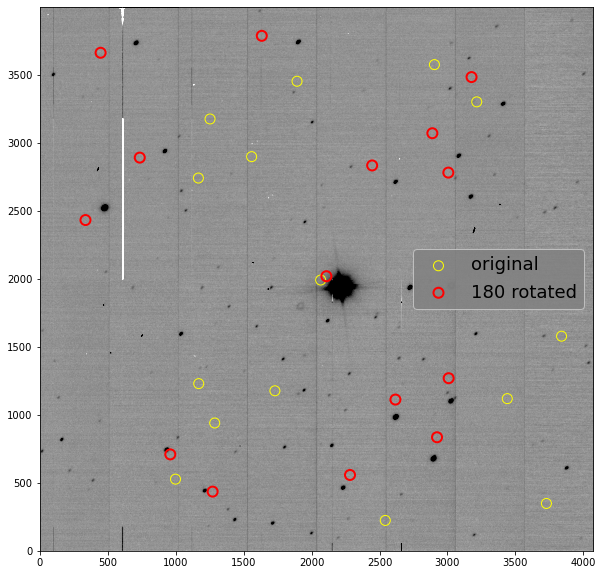

In [70]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
for cat,color,lw,label in zip([originalCatalogMagCut, rotatedCatalogMagCut], 
                    ['yellow', 'red'],
                       [1,2],
                       ['original', '180 rotated']):

    ax.scatter(cat['centroid_x'], 
           cat['centroid_y'], 
           s=100, 
           facecolors='none', edgecolors=color, lw=lw, 
           label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

**The solution:** update the WCS with astrometry task, fitting detected sources against the reference catalog

I pass the postISR with WCS rotated by 180 degrees to the astrometry fitting

Do the astrometry fitting:

In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay



astromConfig = AstrometryTask.ConfigClass()
# Pick your retarget here if necessary
# astromConfig.wcsFitter.retarget(FitAffineWcsTask)
# astromConfig.wcsFitter.retarget(FitTanSipWcsTask)
# astromConfig.referenceSelector.doMagLimit = False
#    You probably *do* want to do a mag limit, because your donuts are
#    unlikely to go as deep as GAIA, and if you have too much choice the matcher
#    will always succeed, but finding false matches with huge scatter.
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.99
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15


Need to redefine filter label

In [73]:
# this is a bit sleezy (as RHL would say) but I'm just forcing the exposure
# to have the same name as the one in the Gaia catalog for now

# this method of making a filter doesn't work anymore ...
# "defineFilter" is deprecated ... 
# referenceFilterName = 'phot_g_mean'
# defineFilter(referenceFilterName, 656.28)
# referenceFilter = afwImage.Filter(referenceFilterName)
# exposure.setFilter(referenceFilter)

# the shift is described  here 
# https://community.lsst.org/t/afw-image-filter-is-now-deprecated/4675 
from lsst.afw.image import FilterLabel
postIsr.setFilterLabel(FilterLabel('phot_g_mean'))

In [74]:

schema = lsst.afw.table.SourceTable.makeMinimalSchema()
solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
results = solver.run(sourceCat=catalog, exposure=postIsr,)

root INFO: Loading reference objects from region bounded by [305.30492316, 308.76327582], [-87.54778646, -87.39601829] RA Dec
root INFO: Loaded 178 reference objects
root INFO: Correcting reference catalog for proper motion to <Time object: scale='tai' format='mjd' value=59466.24454000155>


Now this updated the WCS in the exposure. Use the updated WCS to plot sources again:

In [75]:
updatedDonutCatStruct =  donutCatTask.run(dataRefs, postIsr, )

root INFO: Loading reference objects from region bounded by [305.32830253, 308.66755265], [-87.54229926, -87.39590876] RA Dec
root INFO: Loaded 173 reference objects


In [76]:
updatedCatalog  = updatedDonutCatStruct.donutCatalog

mag_list = (updatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

updatedCatalog['mags'] = mag_array
mask = mag_array<16
updatedCatalogMagCut = updatedCatalog[mask]


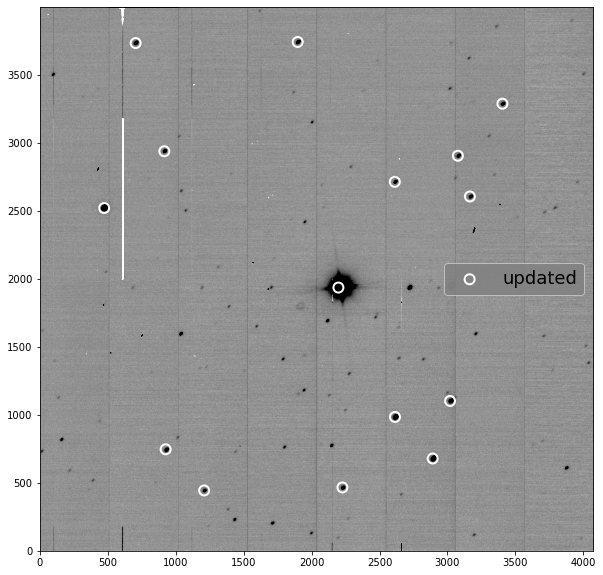

In [77]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
cat = updatedCatalogMagCut
color = 'white'
lw=2
label='updated'

ax.scatter(cat['centroid_x'], 
       cat['centroid_y'], 
       s=100, 
       facecolors='none', 
        edgecolors=color, lw=lw, 
       label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

As we see, good fit! So the astrometry worked correctly to update the WCS. 

Update the WCS in the defocal exposures to that of the in-focus exposure:

In [78]:
focalWcs = postIsr.getWcs()

exposure_intra.setWcs(focalWcs)
exposure_extra.setWcs(focalWcs)

In [80]:
exp_pair = [exposure_intra, exposure_extra]

Run Zernike estimation using the magnitude-cut donut catalog:

In [81]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'onAxis'
# This will take around a minute on medium instance on RSP
zernikeOutput = estimateZernikeTask.run(exp_pair, updatedCatalogMagCut,"LATISS")

In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
0 / 15
imageCoCenter: (x, y) = (   99.32,  101.49)

imageCoCenter: (x, y) = (   99.84,   99.38)

itr = 0, z4-z22
[ -1.  64. -85.  22.  35. -20.  -7. -17.  16.  -0.  -6.  -7.  -7.  -5.
  -1.   1.   3.   2.   6.]
itr = 1, z4-z22
[ -2.  65. -85.  23.  34. -21.  -8. -17.  16.  -0.  -6.  -7.  -6.  -5.
  -0.   1.   3.   2.   6.]
itr = 2, z4-z22
[ -2.  66. -87.  20.  33. -20.  -9. -17.  16.  -1.  -5.  -7.  -6.  -3.
  -0.   1.   3.   2.   6.]
itr = 3, z4-z22
[  -3.   91. -117.   21.   32.  -20.   -9.  -17.   15.   -0.   -5.   -7.
   -5.   -4.   -0.    1.    3.    2.    6.]
itr = 4, z4-z22
[  -3.  108. -138.   22.   33.  -21.   -8.  -17.   14.    0.   -6.   -6.
   -6.   -5.   -0.    1.    2.    2.    6.]
itr = 5, z4-z22
[ -18.  127. -123.    8.   11.  -27.  -12.  -22.   14.   -0.   -5.   -6.
    2.    0.   -0.    0.    3.    2.    7.]
itr 

itr = 6, z4-z22
[  7.  29. -55.  -0.  17. -30.  -6.  -8.   4.   0.   0.  -2.  -2.  -0.
  -0.   3.   2.  -1.   2.]
itr = 7, z4-z22
[  0.  35. -55.  -3.   7. -36.  -7.  -9.   4.   0.   0.  -2.   1.   1.
  -0.   2.   2.  -1.   2.]
itr = 8, z4-z22
[ -7.  40. -54.  -1.  13. -43.  -8. -10.   4.  -0.   0.  -1.  -1.   0.
  -0.   2.   2.  -1.   2.]
itr = 9, z4-z22
[ -5.  43. -54.  -3.  13. -41. -10. -11.   4.   0.   0.  -2.  -1.   1.
  -0.   2.   3.  -2.   2.]
itr = 10, z4-z22
[ -3.  47. -54.  -3.  13. -40. -11. -11.   4.   0.   0.  -3.  -1.   1.
  -0.   2.   4.  -3.   3.]
itr = 11, z4-z22
[ -0.  51. -54.  -1.  15. -39. -12. -12.   4.  -0.   1.  -3.  -2.   0.
  -0.   2.   4.  -3.   3.]
itr = 12, z4-z22
[  2.  54. -54.  -4.  13. -38. -14. -12.   4.   0.   1.  -4.  -1.   1.
  -0.   2.   5.  -4.   3.]
itr = 13, z4-z22
[  3.  57. -53.  -2.  13. -38. -15. -13.   4.   0.   1.  -5.  -1.   0.
  -0.   2.   6.  -5.   3.]
itr = 14, z4-z22
[  5.  60. -53.  -4.  12. -37. -16. -13.   4.   0.   1.  -5.  -1.  

itr = 0, z4-z22
[  7.  18. -17.   3.   4.  -3.   4.  -3.   2.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   0.]
itr = 1, z4-z22
[ 11.  16. -17.   2.   3.  -3.   4.  -3.   2.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   0.]
itr = 2, z4-z22
[ 15.  17. -18.   3.   4.  -3.   4.  -3.   3.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   1.]
itr = 3, z4-z22
[ 19.  26. -28.   2.   3.  -2.   4.  -3.   2.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   1.]
itr = 4, z4-z22
[ 23.  36. -38.   3.   4.  -2.   4.  -3.   2.  -1.  -1.  -1.  -1.  -1.
  -1.   0.  -0.  -0.   1.]
itr = 5, z4-z22
[ 23.  43. -38.  -0.  -1.  -4.   6.  -4.   2.  -1.  -1.  -1.   1.   0.
  -1.   0.  -0.  -0.   1.]
itr = 6, z4-z22
[ 20.  50. -38.   2.   2.  -5.   8.  -5.   2.  -1.  -1.  -1.  -0.  -0.
  -1.   0.  -0.  -0.   1.]
itr = 7, z4-z22
[ 17.  56. -39.  -0.  -0.  -6.  10.  -6.   2.  -1.  -1.  -1.   1.   0.
  -1.  -0.  -0.  -0.   1.]
itr = 8, z4-z22
[ 12.  62. -39.   3.   3.  -7.  12.  -7.   2.  -0.  -1.  -1.  -0.  -1.
 

itr = 9, z4-z22
[  8.  51. -21.   1.   1.   3.  -2.  -7.   1.  -0.  -3.  -3.   1.  -0.
   0.  -1.   1.  -1.   1.]
itr = 10, z4-z22
[  9.  55. -21.   1.  -1.   1.  -3.  -7.   1.  -0.  -4.  -4.   1.  -0.
   0.  -1.   1.  -1.   1.]
itr = 11, z4-z22
[ 10.  59. -22.   1.  -1.  -1.  -3.  -8.   1.  -0.  -4.  -5.   1.  -0.
   0.  -1.   1.  -1.   2.]
itr = 12, z4-z22
[ 11.  64. -22.   1.  -1.  -3.  -3.  -8.   1.  -0.  -5.  -7.   2.  -0.
   0.  -1.   2.  -1.   2.]
itr = 13, z4-z22
[ 13.  68. -22.   2.  -2.  -4.  -3.  -8.   1.  -0.  -6.  -8.   2.  -0.
  -0.  -1.   2.  -1.   2.]
itr = 14, z4-z22
[ 13.  72. -22.   3.  -0.  -6.  -3.  -8.   1.  -0.  -7.  -9.   1.  -1.
  -0.  -1.   2.  -2.   2.]
14 / 15
imageCoCenter: (x, y) = (   98.66,   99.74)

imageCoCenter: (x, y) = (  100.00,   99.46)

itr = 0, z4-z22
[-2. 12. -2. -7.  5. -4. -1. -1.  0. -1. -1. -1. -1.  1.  0. -0. -1. -1.
  1.]
itr = 1, z4-z22
[-4. 12. -1. -7.  5. -3. -1. -1.  0. -1. -1. -1. -1.  2. -0. -0. -1. -1.
  1.]
itr = 2, z4-z22
[-5. 12

Store the results:

In [82]:
# store zernikes as dict
zernikes = zernikeOutput.getDict()
np.save(f'zerDic_auxTel_2021090800487-9.npy',zernikes)

Plot the fit results with donut image:

In [8]:
# plot the truth vs simulation... 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from copy import copy
from lsst.ts.wep.DonutDetector import DonutDetector
import yaml
from astropy.io import fits  
from astropy.visualization import ZScaleInterval

def plot_results_and_image(data=postIsr.image.array, title = 'auxTel,2021090800487-9', 
                 fname = 'auxTel_wcs_updated_2021090800487.png',
                zkResultsFile ='zerDic_auxTel_2021090800487-9.npy',
                           showZkByName = False
                ):
   

    # read the fit results 
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()
    
    # plot the figure ...   
    fig = plt.figure(figsize=(14, 5))
     
    ####################################
    ### left - plot the fit results  ###
    #################################### 
        
    #add_axes([xmin,ymin,dx,dy]) 
    ax1 = fig.add_axes([0,0,0.6,1])  

    for i in range(len(zkFit['outputZernikesRaw'])):
        if i == 8:
            continue
        ax1.plot(np.arange(4, 23),zkFit['outputZernikesRaw'][i], 
                 '-d', label=f'donut {i}')
        ax1.set_xlabel('Zernike Number', size=14)
        ax1.set_ylabel('Avg Zernike Coefficient (microns)', size=14)
        
    
    ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1., 0.5])
    ax1.set_title(title, fontsize=18)
    ax1.set_xticks(np.arange(4,23)[::2])
    ax1.grid()
    
    if showZkByName:
        ax1.set_xticks(np.arange(4,23))
        ax1.set_xticklabels(['z4: Defocus', 'z5: Vertical Astigmatism', 
                            'z6: Vertical Trefoil', 'z7: Vertical Coma',
                           'z8: Horizontal Coma', 'z9: Obliue Trefoil',
                           'z10: Oblique Quadrafoil', 'z11: Oblique Secondary Astigmatism',
                           'z12: Primary Spherical', 'z13: Vertical Secondary Astigmatism',
                           'z14: Vertical Quadrafoil', 
                           'z15: Vertical Pentafoil', 'z16: Vertical Secondary Trefoil', 
                           'z17: Vertical Secondary Coma',
                           'z18: Horizontal Secondary Coma', 
                           'z19: Oblique Secondary Trefoil', 
                           'z20:Oblique Pentafoil', 
                           'z21','z22'])
        ax1.tick_params(axis="x", rotation=270)
        # https://www.delftstack.com/howto/matplotlib/how-to-rotate-x-axis-tick-label-text-in-matplotlib/#fig.autofmt_xdaterotation-to-rotate-xticks-label-text
        #fig.autofmt_xdate(rotation=45)
    ###############################################
    ### right - plot the simulated donuts image ###
    ###############################################
    
    
    ax2 = fig.add_axes([0.7,0,0.4,1])

    # get the vmin, vmax 
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)
    nrows = len(zkFit['donutStampsExtra'])
    for i in range(nrows):
        donut = zkFit['donutStampsExtra'][i]
        xy = donut.centroid_position

        # plot the cross marking that the donut was used 
        ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)

        # plot the donut number on the plot 
        xtext,ytext = xy[0],xy[1]
        ytext -= 60
        if xtext+100 > 4096:
            xtext -= 250
        if len(str(i))>1: # move to the left label thats too long 
            #print(i, 'moving')
            xtext -=340 
        else:
            xtext -=260
        ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
    ax2.yaxis.tick_right()
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.yaxis.set_label_position("right")
    # save the plot 
    plt.savefig(fname, bbox_inches='tight')

NameError: name 'postIsr' is not defined

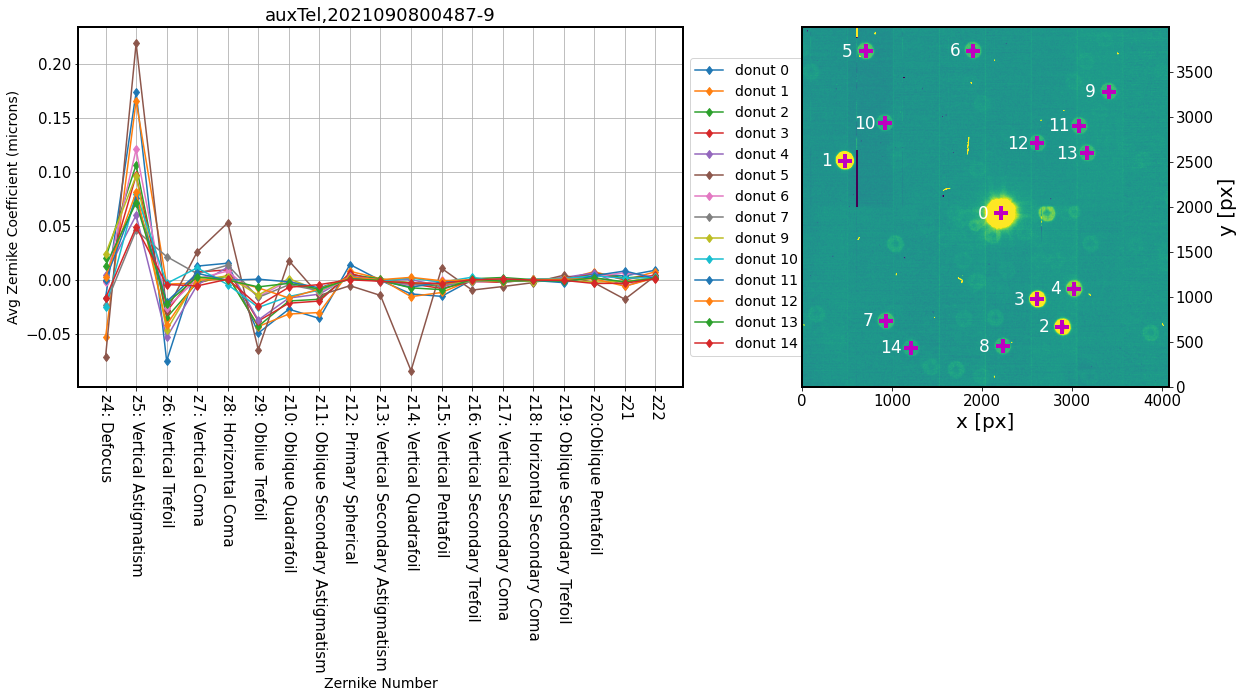

In [123]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

plot_results_and_image(exposure_extra.image.array, showZkByName=True)

Show the donut cutouts:

In [4]:
import numpy as np
zkResultsFile ='zerDic_auxTel_2021090800487-9.npy'
zernikeOutput = np.load(zkResultsFile, allow_pickle=True).item()

In [6]:
zernikeOutput['donutStampsExtra']

In [7]:
nrows = len(zernikeOutput['donutStampsExtra'])
fig,ax = plt.subplots(nrows,2,figsize=(2*nrows, 4*nrows))

for i in range(nrows):
    donut = zernikeOutput['donutStampsExtra'][i]
    ax[i,0].imshow(donut.stamp_im.getArrays()[0], origin='lower')
    
    donut = zernikeOutput['donutStampsIntra'][i]
    ax[i,1].imshow(donut.stamp_im.getArrays()[0], origin='lower')
    ax[i,0].set_title(f'Donut {i}')
ax[0,0].set_title('Extra')
ax[0,1].set_title('Intra')

NameError: name 'plt' is not defined

Next: Incorporate this code to the `ts_wep` task